<a href="https://colab.research.google.com/github/zhousanfu/tensorflow_demo/blob/master/tensorflow_textclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 需要模块

In [ ]:
# !pip install -q tensorflow-datasets
# !pip install tensorflow
import tensorflow_datasets as tfds
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import pandas as pd
import io, time
from google.colab import drive
drive.mount('/content/drive')
# from sklearn.datasets.samples_generator import make_blobs
# from sklearn.preprocessing import MinMaxScaler

## 1.1 数据预处理

In [ ]:
# pd_all = pd.read_csv('tmp/imo_all.csv', sep='\t', encoding='utf-8')
pd_all = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/imo_train_user_profile_20210130-20210331.csv')
pd_all = shuffle(pd_all)
review_data, label_data = pd_all.review.replace(r'\n\t\r', '', regex=True), pd_all.label
training_sentences, testing_sentences, training_labels, testing_labels = train_test_split(review_data, label_data, test_size=0.1, shuffle=shuffle)
print(training_sentences.shape, training_labels.shape, testing_sentences.shape, testing_labels.shape)

training_sentences = [' '.join(str(x).replace('\n', '').replace('\r', '').replace(';', ' ').split()) for x in training_sentences.tolist()]
testing_sentences = [' '.join(str(x).replace('\n', '').replace('\r', '').replace(';', ' ').split()) for x in testing_sentences.tolist()]
training_labels = training_labels.tolist()
testing_labels = testing_labels.tolist()
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


# train_and_label = tf.data.Dataset.from_tensor_slices((np.array(training_sentences), training_labels_final))
# test_and_label = tf.data.Dataset.from_tensor_slices((np.array(testing_sentences), testing_labels_final))
# # <PrefetchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>
# print(train_and_label.shard)
# print(test_and_label.shard)

(449999,) (449999,) (50000,) (50000,)


## 2.1 超参数设置

In [ ]:
MAX_NB_WORDS = 50000      # 设置最频繁使用的XXX个词
MAX_SEQUENCE_LENGTH = 256   # 文本最大的长度
EMBEDDING_DIM = 16       # 设置Embeddingceng层的维度
TRUNC_TYPE = 'post'
OOV_TOK = '<oov>'

### 2.1.1 文字向量

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, oov_token=OOV_TOK)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH, truncating=TRUNC_TYPE)
testing_sentences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sentences, maxlen=MAX_SEQUENCE_LENGTH)

## 2.2 定义模型
网络-损失函数和优化器

### 2.2.1 基本

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          800000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 800,289
Trainable params: 800,289
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 10

history = model.fit(
  training_padded,
  training_labels_final,
  epochs=num_epochs,
  batch_size=MAX_SEQUENCE_LENGTH,
  validation_data=(testing_padded, testing_labels_final),
  verbose=1
  )

Epoch 1/10
1758/1758 [==============================] - 27s 15ms/step - loss: 0.4311 - accuracy: 0.8750 - val_loss: 0.3467 - val_accuracy: 0.8743
Epoch 2/10
1758/1758 [==============================] - 26s 15ms/step - loss: 0.3050 - accuracy: 0.8852 - val_loss: 0.2606 - val_accuracy: 0.9020
Epoch 3/10
1758/1758 [==============================] - 26s 15ms/step - loss: 0.2450 - accuracy: 0.9087 - val_loss: 0.2421 - val_accuracy: 0.9122
Epoch 4/10
1758/1758 [==============================] - 26s 15ms/step - loss: 0.2251 - accuracy: 0.9169 - val_loss: 0.2306 - val_accuracy: 0.9164
Epoch 5/10
1758/1758 [==============================] - 26s 15ms/step - loss: 0.2091 - accuracy: 0.9229 - val_loss: 0.2233 - val_accuracy: 0.9207
Epoch 6/10
1758/1758 [==============================] - 26s 15ms/step - loss: 0.1972 - accuracy: 0.9269 - val_loss: 0.2203 - val_accuracy: 0.9205
Epoch 7/10
1758/1758 [==============================] - 26s 15ms/step - loss: 0.1887 - accuracy: 0.9307 - val_loss: 0.2177 -

### 2.2.2 RNN

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(tf.keras.layers.SpatialDropout1D(0.2))
model.add(tf.keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

In [ ]:
epochs = 5
batch_size = 64
 
history = model.fit(
    X_train,
    Y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]
    )

### 2.2.3 TF-Hub

In [ ]:
%%bash
curl -O https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.bn.300.vec.gz
curl -O https://raw.githubusercontent.com/tensorflow/hub/master/examples/text_embeddings_v2/export_v2.py
gunzip -qf cc.bn.300.vec.gz --k

python export_v2.py --embedding_file=cc.bn.300.vec --export_path=text_module --num_lines_to_ignore=1 --num_lines_to_use=100000

In [ ]:
import tensorflow_hub as hub
module_path = "text_module"
embedding_layer = hub.KerasLayer(module_path, input_shape=[], dtype=tf.string, trainable=False)
embedding_layer(train_and_label[:1])

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=[], dtype=tf.string),
  embedding_layer,
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid"),
  ])
model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer="adam", metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(
  train_and_label,
  validation_data=(test_and_label),
  epochs=5,
  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3)]
  )

## 2.3 tpu训练

In [ ]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)
with strategy.scope():
  model = tf.keras.Sequential([
              tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
              tf.keras.layers.Flatten(),
              # tf.keras.layers.GlobalAveragePooling1D()
              tf.keras.layers.Dense(6, activation='relu'),
              tf.keras.layers.Dense(1, activation='sigmoid')
              ])
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

num_epochs = 5

history = model.fit(
    training_padded,
    training_labels_final,
    epochs=num_epochs,
    validation_data=(testing_padded, testing_labels_final),
    verbose=2
    )

INFO:tensorflow:Initializing the TPU system: grpc://10.51.52.2:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.51.52.2:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Epoch 1/5
1215/1215 - 11s - loss: 0.2170 - accuracy: 0.9372 - val_loss: 0.2031 - val_accuracy: 0.9409
Epoch 2/5
1215/1215 - 7s - loss: 0.1663 - accuracy: 0.9408 - val_loss: 0.1959 - val_accuracy: 0.9370
Epoch 3/5
1215/1215 - 7s - loss: 0.1365 - accuracy: 0.9469 - val_loss: 0.2183 - val_accuracy: 0.9240
Epoch 4/5
1215/1215 - 7s - loss: 0.1171 - accuracy: 0.9535 - val_loss: 0.2349 - val_accuracy: 0.9310
Epoch 5/5
1215/1215 - 7s - loss: 0.1026 - accuracy: 0.9580 - val_loss: 0.2695 - val_accuracy: 0.9226


## 3.1 loss可视化

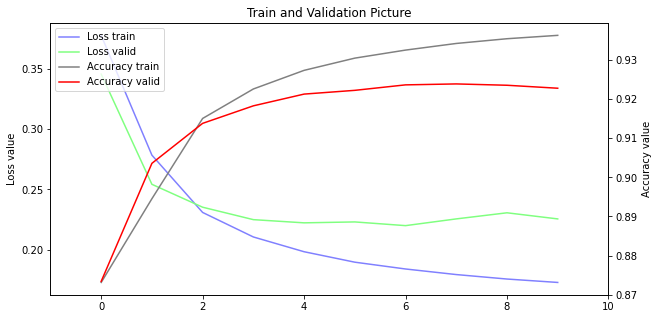

In [ ]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
ax1 = fig.add_subplot(111)
ax1.set_title('Train and Validation Picture')
ax1.set_ylabel('Loss value')
line1, = ax1.plot(history.history['loss'], color=(0.5, 0.5, 1.0), label='Loss train')
line2, = ax1.plot(history.history['val_loss'], color=(0.5, 1.0, 0.5), label='Loss valid')
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy value')
line3, = ax2.plot(history.history['accuracy'], color=(0.5, 0.5, 0.5), label='Accuracy train')
line4, = ax2.plot(history.history['val_accuracy'], color=(1, 0, 0), label='Accuracy valid')
plt.legend(handles=(line1, line2, line3, line4), loc='best')
plt.xlim(-1, 10)
plt.show()

## 3.2 向量反转

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_review(text):
  return ' '.join([reverse_word_index.get(i, '0') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

## 3.3 模型保存

In [ ]:
# # 保存模型结构
# json_config = model.to_json()
# with open('model_config.json', 'w') as json_file:
#   json_file.write(json_config)

# ## HDF5 文件,单个二进制 blob，里面同时保存了模型权重、模型结构和优化器配置
# model.save_weights('path_to_my_weights.h5')

# SavedModel,使用 TensorFlow Serving 来部署模型时必须使用 SavedModel 格式
tf.keras.models.save_model(model, './saved_models/1')

# # checkpoint格式
# model.save_weights("xxx.ckpt", save_format="tf")

## 4.1 模型预测

### 4.1.1 predict

In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/imo_discover_comment_data_20210101-20210330.csv', sep='\t')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/imo_test_tmp_imomsg_encrypt_20210411.csv')
df_data = df.values.tolist()
data = []
data_line = []
my_test_sentences = df['a.msg'].values.tolist()
text_sentences = tokenizer.texts_to_sequences([str(s) for s in my_test_sentences])
my_text_padded = pad_sequences(text_sentences, maxlen=MAX_SEQUENCE_LENGTH)

predictions = model.predict(my_text_padded)
print('my_test_sentences len=', len(my_test_sentences), my_test_sentences[0])
print('my_text_padded len=', len(my_text_padded), my_text_padded[0])
if predictions.shape[-1] > 1:
  predictions_classes = predictions.argmax(axis=-1)
else:
  predictions_classes = (predictions > 0.5).astype('int32')

for i in range(len(predictions)):
  if int(predictions_classes[i][0]) >= 1:
    data_line.append(i)

for i in data_line:
  data.append([df_data[i][0],df_data[i][1],predictions[i][0],predictions_classes[i][0]])


print('data_lin len=', len(data_line), data_line[0])
print('data_len len=', len(data), data[0])
# df = pd.DataFrame(data, columns=['day', 'opt_type', 'message', 'resource_id', 'comment_id', '得分', '标签(1=违规)'])
df = pd.DataFrame(data, columns=['clo_1', 'clo_2', '得分', '标签(1=违规)'])
df.to_excel("/content/drive/MyDrive/Colab Notebooks/data/预测_tmp_imomsg_encrypt.xlsx", index=False, sheet_name='Sheet1', encoding='utf-8')

my_test_sentences len= 499999 👍
my_text_padded len= 499999 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0   

### 4.1.2 evaluate

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/imo_test_user_profile.csv')
my_test_content = df['content'].values.tolist()
my_test_label = df['label'].values.tolist()

test_sentences = tokenizer.texts_to_sequences([str(s) for s in my_test_content])
test_padded = pad_sequences(test_sentences, maxlen=MAX_SEQUENCE_LENGTH)

loss, accuracy = model.evaluate(test_padded, np.array(my_test_label))
print('test loss',loss)
print('accuracy',accuracy)

15625/15625 [==============================] - 31s 2ms/step - loss: 0.2232 - accuracy: 0.9177
test loss 0.22322627902030945
accuracy 0.9177398085594177


## 5.1 Tensorflow Server

In [ ]:
!curl -sSL https://get.daocloud.io/docker | sh
!docker pull tensorflow/serving
!curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update
!apt-get install tensorflow-model-server

In [ ]:
import os
os.environ["MODEL_DIR"] = "/content/saved_models"
!ls -l /content/saved_models
!saved_model_cli show --dir /content/saved_models/1 --all

In [ ]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=helloworld \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [ ]:
import json
import requests

def get_model_predict(list_data):
  headers = {"content-type": "application/json"}
  req_data = {"signature_name": "serving_default", "instances": list_data.tolist()}
  json_response = requests.post('http://localhost:8501/v1/models/helloworld/versions/1:predict/classes', data=json.dumps(req_data), headers=headers)

  return json_response


my_test_sentences = pd.read_excel('imo_v1.xlsx', usecols=[2]).values.tolist()

my_test_sentences = tokenizer.texts_to_sequences(['আপু রা এড দাও মজা পাবে আসো'])
my_test_data_padded = pad_sequences(my_test_sentences, maxlen=max_length)
json_response = get_model_predict(my_test_data_padded)
print(json_response.json())